# Working with the LINCS L1000 data
---

### _Zichen Wang, PhD_
### _Ma'ayan Lab_
### _Icahn School of Medicine at Mount Sinai_
### _New York, NY_
### <i>BSR6806_SP_19 Programming for Big Data Biomedicine, Spring 2019</i>
### _February 26, 2019_

---

# 1. Introduction

## 1.1. What is LINCS?

- **Library of Integrated Network-Based Cellular Signatures (LINCS) Program**
- An [NIH Common Fund](https://commonfund.nih.gov/) program 

![](img/LINCS_review_fig1.jpg)
[Keenan _et al_. 2018 _Cell Systems_](https://doi.org/10.1016/j.cels.2017.11.001)

### Overall goal of LINCS:

- Establish a new understanding of health and disease through an integrative approach that identifies patterns of common networks and **cellular signatures** across different types of tissues and cells in response to a broad range of perturbations.

![](img/LINCS_perturbation_signatures.png)


### Cellular signatures and the Connectivity Map concept

- A vector of molecular readouts (gene expression, proteomics, imaging and etc.) from human cells in response to a perturbagen.
- Can be used to propose perturbagens for manipulating biological states (Connectivity Map concept):

![](img/CMap_concept.png)
[Lamb _et al_. 2006 _Science_](https://www.ncbi.nlm.nih.gov/pubmed/17008526)


## 1.2. The L1000 technology

- Gene expression are highly correlated and can be approximately represented by ~1000 carefully picked genes: 
    ![](img/L1000_recovered_connections.png)
    
    
- Ligation-mediated amplification of the 1000 transcripts:
    ![](img/L1000_ligation_based_amplification.png)
    
    
- Deconvoluting 1000 landmark genes using 500 bead colors:
    <img src="img/L1000_deconvolution.png" width="500px" />
    
- High-throughput: 200 x 384-well plates / week    
- The first published batch of L1000 data covers > 25,000 perturbagens across many dosages and time points:
    <img src="img/L1000_data_perturbations.png" width="500px" />
    
[Subramanian _et al_. 2017 _Cell_](https://www.ncbi.nlm.nih.gov/pubmed/29195078)


# 2. Computational processing of L1000 data

## 2.1. Signature generation and data levels

![](img/L1000_data_levels.png)

Data are available for download at: [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)

## 2.2. Analyze the L1000 data

### 2.2.1. Explore batch effects in the Level 3 data
**Level 3 (Q2NORM)**: contains the gene expression profiles of both directly measured landmark transcripts plus inferred genes. This data is normalized using invariant set scaling followed by quantile normalization.


In [1]:
!ls -lh data/

total 83G
-rw-r--r--  1 jovyan users 608K Nov 19 15:47 GSE92742_Broad_LINCS_gene_info.txt
-rw-r--r--  1 jovyan users 142M Nov 19 15:47 GSE92742_Broad_LINCS_inst_info.txt
-rw-r--r--  1 jovyan users  61G Nov 19 20:00 GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx
-rw-r--r--  1 jovyan users  22G Nov 19 15:54 GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
-rw-r--r--  1 jovyan users 4.6M Nov 19 15:48 GSE92742_Broad_LINCS_pert_info.txt
-rw-r--r--  1 jovyan users 101M Nov 19 15:48 GSE92742_Broad_LINCS_sig_info.txt
-rw-r--r--  1 jovyan users  49M Nov 19 15:48 GSE92742_Broad_LINCS_sig_metrics.txt
-rw-r--r--  1 jovyan users 1.2M Nov 29 15:36 MACCS_bitmatrix.csv.gz
-rw-r--r--  1 jovyan users 565K Nov 28 17:54 parsed_Repurposing_Hub.csv
drwxr-xr-x 12 jovyan users  408 Dec 20 19:17 processed_CS_pred_GE
-rw-r--r--  1 jovyan users 1.4M Nov 27 21:03 Repurposing_Hub_export_2018.txt
drwxr-xr-x  5 jovyan users  170 Nov 30 16:11 results
-rw-r--r--  1 jovyan users 166K Nov 29 15:36 S

In [2]:
import os, sys
import warnings
warnings.filterwarnings("ignore")
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold, metrics
np.random.seed(2018)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='whitegrid')

In [3]:
# Costom helper functions
import plots
import gctx_utils
import graph_utils
import benchmarks

In [4]:
DATA_DIR = 'data/'

#### Parsing the metadata 
- Mapping genes
- Mapping instances: corresponds to a well on the 386-well plate

In [5]:
gene_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_gene_info.txt' % DATA_DIR, 
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
gene_info_df.head()

(12328, 4)


,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
pr_gene_id,,,,
780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
7849,PAX8,paired box 8,1,1
2978,GUCA1A,guanylate cyclase activator 1A,0,0
2049,EPHB3,EPH receptor B3,0,1
2101,ESRRA,estrogen related receptor alpha,0,1


In [6]:
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENES = gene_info_df.loc[LM_GENE_IDS, 'pr_gene_symbol']
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print(len(LM_GENE_IDS), len(LM_GENES))

978 978


In [7]:
# Metadata of instances
inst_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_inst_info.txt' % DATA_DIR, 
                          sep='\t')
inst_info_df.set_index(inst_info_df.columns[0], inplace=True)
print(inst_info_df.shape)
inst_info_df.head()

(1319138, 10)


,rna_plate,rna_well,pert_id,pert_iname,pert_type,pert_dose,pert_dose_unit,pert_time,pert_time_unit,cell_id
inst_id,,,,,,,,,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13,ASG001_MCF7_24H_X1,F13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13,ASG001_MCF7_24H_X1,G13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13,ASG001_MCF7_24H_X1,I13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13,ASG001_MCF7_24H_X1,K13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13,ASG001_MCF7_24H_X1,N13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7


In [8]:
inst_info_df['pert_type'].value_counts()

trt_cp         672128
trt_sh         448737
trt_oe          87765
ctl_vector      30400
ctl_vehicle     28463
trt_lig         25739
ctl_untrt       22072
trt_oe.mut       3834
Name: pert_type, dtype: int64

In [9]:
# Select compound treatment (trt_cp) and their controls (ctr_vehicle)
inst_info_df = inst_info_df.loc[inst_info_df['pert_type'].isin(['trt_cp', 'ctl_vehicle'])]
print(inst_info_df.shape)

(700591, 10)


In [10]:
# Find the top cell lines
inst_info_df['cell_id'].value_counts().head(10)

VCAP      125539
MCF7      103448
PC3        96014
A549       60622
A375       54971
HT29       53436
HA1E       32613
HCC515     27449
HEPG2      19019
NPC        15060
Name: cell_id, dtype: int64

In [11]:
# Only examine samples from PC3 cell line
# but you can select any other cell lines
inst_info_df = inst_info_df.query('cell_id == "PC3"')
# inst_info_df = inst_info_df.query('cell_id == "NPC"')
inst_info_df.shape

(96014, 10)

In [12]:
inst_info_df.pert_type.value_counts()

trt_cp         91954
ctl_vehicle     4060
Name: pert_type, dtype: int64

In [13]:
# Extract pert_plate and det_plate from the instance_id
inst_info_df['batch'] = inst_info_df['rna_plate'].map(lambda x: '_'.join(x.split('_')[:3]))
inst_info_df['pert_plate'] = inst_info_df['rna_plate'].map(lambda x: x.split('_')[0])
inst_info_df['det_plate'] = inst_info_df.index.map(lambda x: x.split(':')[0])

In [14]:
inst_info_df.head()

,rna_plate,rna_well,pert_id,pert_iname,pert_type,pert_dose,pert_dose_unit,pert_time,pert_time_unit,cell_id,batch,pert_plate,det_plate
inst_id,,,,,,,,,,,,,
ASG001_PC3_24H_X2_B7_DUO52HI53LO:E01,ASG001_PC3_24H_X2,E01,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,PC3,ASG001_PC3_24H,ASG001,ASG001_PC3_24H_X2_B7_DUO52HI53LO
ASG001_PC3_24H_X2_B7_DUO52HI53LO:F01,ASG001_PC3_24H_X2,F01,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,PC3,ASG001_PC3_24H,ASG001,ASG001_PC3_24H_X2_B7_DUO52HI53LO
ASG001_PC3_24H_X2_B7_DUO52HI53LO:G01,ASG001_PC3_24H_X2,G01,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,PC3,ASG001_PC3_24H,ASG001,ASG001_PC3_24H_X2_B7_DUO52HI53LO
ASG001_PC3_24H_X2_B7_DUO52HI53LO:K13,ASG001_PC3_24H_X2,K13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,PC3,ASG001_PC3_24H,ASG001,ASG001_PC3_24H_X2_B7_DUO52HI53LO
ASG001_PC3_24H_X2_B7_DUO52HI53LO:N13,ASG001_PC3_24H_X2,N13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,PC3,ASG001_PC3_24H,ASG001,ASG001_PC3_24H_X2_B7_DUO52HI53LO


In [15]:
# Select samples from two batches 
inst_ids_sample = inst_info_df.loc[inst_info_df['batch'].isin(['CPC001_PC3_24H', 'CPC006_PC3_24H'])]
inst_ids_sample.shape

(4389, 13)

In [16]:
# Level 3 data
gctx3 = h5py.File('%s/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx' % DATA_DIR, 'r')

In [17]:
# Retrieve the slice of the expression matrix from the gctx file
mat = gctx_utils.slice_matrix(gctx3,
                   rids=LM_GENE_IDS,
                   cids=inst_ids_sample.index.values.astype(np.str)
                   )
mat.shape

(4389, 978)

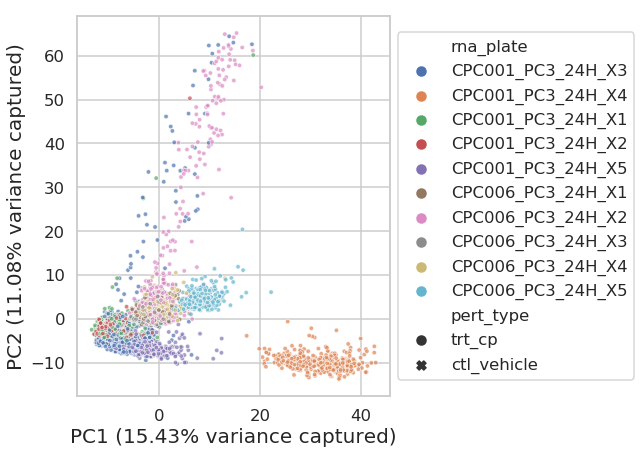

In [18]:
fig = plots.PCA_plot(mat.T, inst_ids_sample, hue='rna_plate', style='pert_type', standardize=3)

In [19]:
# Convert expression 2d-array to a data frame
expr_df = pd.DataFrame(mat, index=inst_ids_sample.index, 
                       columns=LM_GENES)
expr_df.shape

(4389, 978)

In [20]:
# Find the most variable genes across rna_plates
expr_df['rna_plate'] = inst_ids_sample['rna_plate']

expr_df_mean_by_rna_plate = expr_df.groupby('rna_plate').mean()
gene_variances = expr_df_mean_by_rna_plate.var(axis=0)

gene_variances.sort_values(ascending=False).head()

pr_gene_symbol
CLIC4     8.145939
MAP7      5.553699
PYCR1     5.108848
RNF167    5.069213
STX1A     4.584454
dtype: float32

In [21]:
top_variable_genes = gene_variances.sort_values(ascending=False).head().index

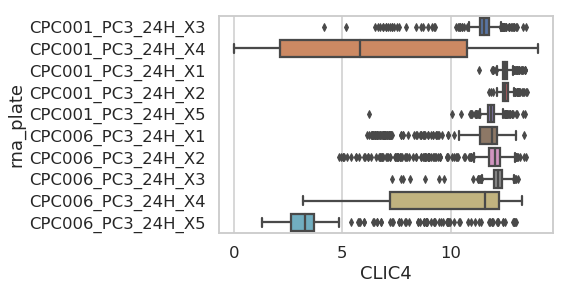

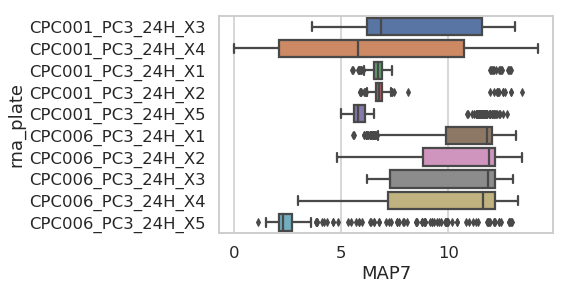

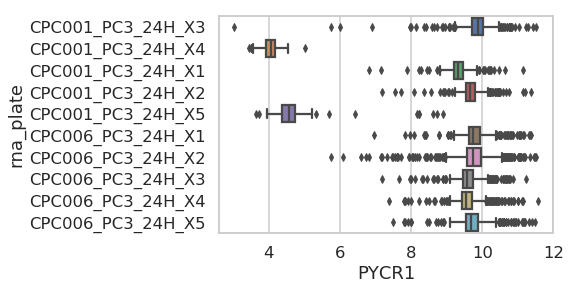

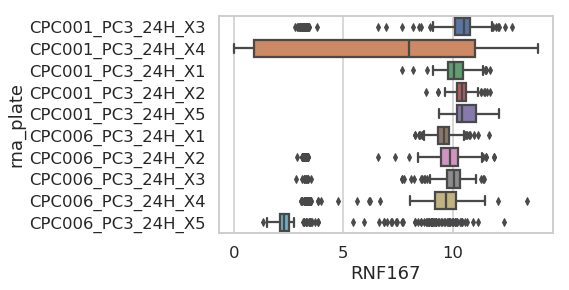

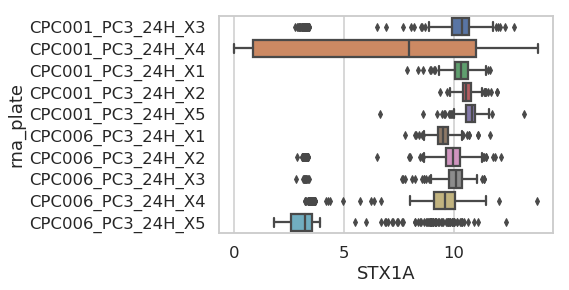

In [22]:
for gene in top_variable_genes:
    sns.boxplot(x=gene, y='rna_plate', data=expr_df)
    plt.show()

### 2.2.2. Explore Level 5 data

**Level 5 (MODZ)** replicate-collapsed z-score vectors based on Level 4. Replicate collapse generates one differential expression vector, which we term a signature. Connectivity analyses are performed on signatures.

In [24]:
# Parsing the signature-level metadata
sig_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_sig_info.txt' % DATA_DIR, 
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
print(sig_info_df.shape)
sig_info_df.head()

(473647, 11)


,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
sig_id,,,,,,,,,,,
AML001_CD34_24H:A05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:A05
AML001_CD34_24H:A06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:A06
AML001_CD34_24H:B05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...
AML001_CD34_24H:B06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:B06
AML001_CD34_24H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,CD34,0.37037,µM,500 nM,24,h,24 h,AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...


In [25]:
# Select a subset of compound treatment signatures from PC3 cells
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
# remove signatures with only one distil_id
sig_info_df['n_distil_ids'] = sig_info_df['distil_id'].map(lambda x: len(x.split('|')))
sig_info_df = sig_info_df.query('n_distil_ids > 1')
print(sig_info_df.shape)

(22664, 12)


In [26]:
sig_info_df['pert_iname'].value_counts().head(10)

vorinostat        173
wortmannin        126
trichostatin-a    125
geldanamycin      121
LY-294002          49
fulvestrant        49
panobinostat       37
sirolimus          35
troglitazone       33
PCI-34051          32
Name: pert_iname, dtype: int64

In [27]:
# Only look at the signatures from the top drugs
top10_pert_ids = sig_info_df['pert_id'].value_counts().head(10).index
sig_info_df_sub = sig_info_df.loc[sig_info_df['pert_id'].isin(
    top10_pert_ids
)]
sig_info_df_sub.shape

(762, 12)

In [28]:
# Load level5 data
gctx5 = h5py.File('%s/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx' % DATA_DIR, 'r')
mat5 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                               cids=sig_info_df_sub.index.values.astype(np.str))
mat5.shape

(762, 978)

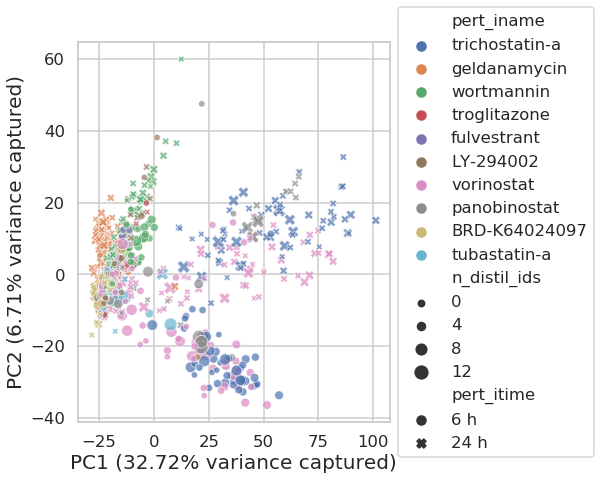

In [29]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)

In [30]:
# Perform t-SNE
mat5_tsne, sig_info_df_sub = benchmarks.perform_tsne_and_clustering(mat5, sig_info_df_sub, 
                                                                    sig_name='MODZ')

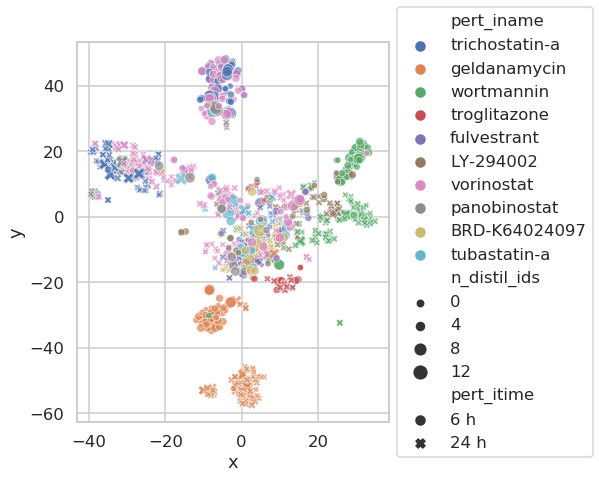

In [31]:
fig = plots.scatter_plot(mat5_tsne, sig_info_df_sub, hue='pert_iname',
                         style='pert_itime', 
                         size='n_distil_ids',
                        )

In [32]:
# An interactive t-SNE plot
plots.plotly_webgl_scatter(mat5_tsne, sig_info_df_sub, 
                     hue='pert_iname', 
                     label_cols=['pert_iname', 'pert_itime', 'pert_idose'])

### Graph-based dimensionality reduction for L1000 signatures

**Workflow:**

1. Starts with $\mathbf{X}$ ($n \times m$ signatures by genes)
1. Compute pairwise distance/similarity matrix -> $\mathbf{A}$ ($n \times n$)
1. Construct a graph $G$ to represent the local and global geometric/topological structures of the data, the graph can be a k-Nearest Neighbor graph
1. Project $G$ into lower-dimensional space using graph layout algorithms, e.g., [Fruchterman-Reingold force-directed layout](https://onlinelibrary.wiley.com/doi/abs/10.1002/spe.4380211102), edge-repulsive strong clustering and others.


In [33]:
G = graph_utils.create_knn_graph(mat5, k=3, metric='cosine', n_jobs=6)
G.number_of_nodes(), G.number_of_edges()

(762, 1926)

In [34]:
# Convert to igraph.Graph
G = graph_utils.nx_graph_to_igraph(G)
# Perform Fruchterman-Reingold force-dirceted layout algorithm for the graph
layt = G.layout_fruchterman_reingold_3d(maxdelta=1500, maxiter=1000) 

In [35]:
plots.plotly_network(G, layt, sig_info_df_sub,
                          hue='pert_iname',
                          label_cols=['pert_iname', 'pert_itime', 'pert_idose'])

# 3. Query L1000 signatures through LINCS web-based tools

## 3.1. [L1000FWD](http://amp.pharm.mssm.edu/L1000FWD/): fireworks visualization of drug-induced transcriptomic signatures.

![](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/bioinformatics/34/12/10.1093_bioinformatics_bty060/1/bty060f1.png?Expires=1550961111&Signature=snjuNDaWCq1jQL2MFyT7YJMZzyVK11KRGUgiMNbshhFRUnvLLg75FOUHUxDMEsE653bY-F8URsOrYs9N6-~4vgtCCCwF26odCaKct-XGMfTbejm53qMI6qgJfaY57p6yFWNGSF-Uu8PWbPlfdUH~4Ys~kv8VrJKCjJNLdBtN3HkIGFiXp6tJGYo8d1DhvDKwvDXx8pT-BINjQybcMNhMTTcADKbeNFMF3S9AJhD7~NdLpraqRUuALZyHIjIq2kld6tUUyQFKb3HzXvX1EgqevM1jCuRZM13v2wzzizHTQzFxrYTgNupg2TVzgfQHeTvRn4R8PzN~iOn5Ob-NEQ7pwQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

## 3.2. [clue.io](https://clue.io/)

![](img/clue_io_query.png)

# 4. Machine Learning applications with the L1000 signatures

## Application of multi-label classification to predict drug side effects/ADRs

![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4965635/bin/btw168f1p.jpg)

[Wang Z, Clark NR, Ma'ayan A (2016) _Bioinformatics_](https://www.ncbi.nlm.nih.gov/pubmed/27153606)

# References

- [Keenan _et al_. (2018) The Library of Integrated Network-Based Cellular Signatures NIH Program: System-Level Cataloging of Human Cells Response to Perturbations. _Cell Systems_](https://www.ncbi.nlm.nih.gov/pubmed/29199020)
- [Lamb _et al_. (2006) The Connectivity Map: using gene-expression signatures to connect small molecules, genes, and disease. _Science_](https://www.ncbi.nlm.nih.gov/pubmed/17008526)
- [Subramanian _et al_. (2017) A Next Generation Connectivity Map: L1000 Platform and the First 1,000,000 Profiles. _Cell_](https://www.ncbi.nlm.nih.gov/pubmed/29195078)
- [Wang, Lachmann, Keenan, Ma'ayan (2018) L1000FWD: fireworks visualization of drug-induced transcriptomic signatures. _Bioinformatics_](https://www.ncbi.nlm.nih.gov/pubmed/29420694)
- [Wang, Clark, Ma'ayan (2016) Drug-induced adverse events prediction with the LINCS L1000 data. _Bioinformatics_](https://www.ncbi.nlm.nih.gov/pubmed/27153606)